In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
@common.memoize_xarray_out
def get_global_avg(group, field):
    data = common.open_group(group)
    # data is already on pressure levels
    return vcm.weighted_average(data[field], data.area).load().to_dataset()

Make it faster

In [3]:
base = "combined-zcemu-monthly-init-m{init}-30d-v1-{run_type}"
fields = [
    "air_temperature",
    "specific_humidity",
    "cloud_water_mixing_ratio"
]
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [4]:

args = list(product(inits, run_types, fields))
jobs = []

for init, run_type, field in args:
    group = base.format(init=init, run_type=run_type)
    jobs.append(delayed(get_global_avg)(group, field))

    

In [5]:
results = Parallel(n_jobs=12)(jobs)

In [6]:
results[0]

<xarray.Dataset>
Dimensions:          (z: 79, time: 240)
Coordinates:
  * z                (z) float64 4.514 8.301 12.45 16.74 ... 989.5 994.4 998.3
  * time             (time) object 2016-01-31 03:00:00 ... 2016-03-01 00:00:00
Data variables:
    air_temperature  (time, z) float64 ...

In [7]:
args[0]

('01', 'online', 'air_temperature')

In [8]:
def gather(field_key, args, results, drop_time=False):
    out = defaultdict(list)

    for i, ds in enumerate(results):
        month, run_type, field = args[i]
        if field == field_key:
            if drop_time:
                ds = ds.drop_vars(["time"])
            out[run_type].append(ds)
    
    out["offline"] = xr.concat(out["offline"], dim="init")
    out["online"] = xr.concat(out["online"], dim="init")
    
    return out

In [9]:
cloud = gather("cloud_water_mixing_ratio", args, results, drop_time=True)

In [ ]:
cloud_water.coords

In [30]:
def get_bias(key, args, results, pct=False):
    fields = gather(key, args, results, drop_time=True)
    online_ds = fields["online"][key]
    offline_ds = fields["offline"][key]
    bias = (online_ds - offline_ds).mean(dim="init")
    baseline = offline_ds.mean(dim="init")

    if pct:
        bias /= baseline

    # correct method is to update time to deltas so they overlap
    sim_time = [(i+1) * 3 / 24 for i in range(len(bias.time))]
    bias.coords["time"] =  sim_time
    baseline.coords["time"] =  sim_time
    return baseline, bias

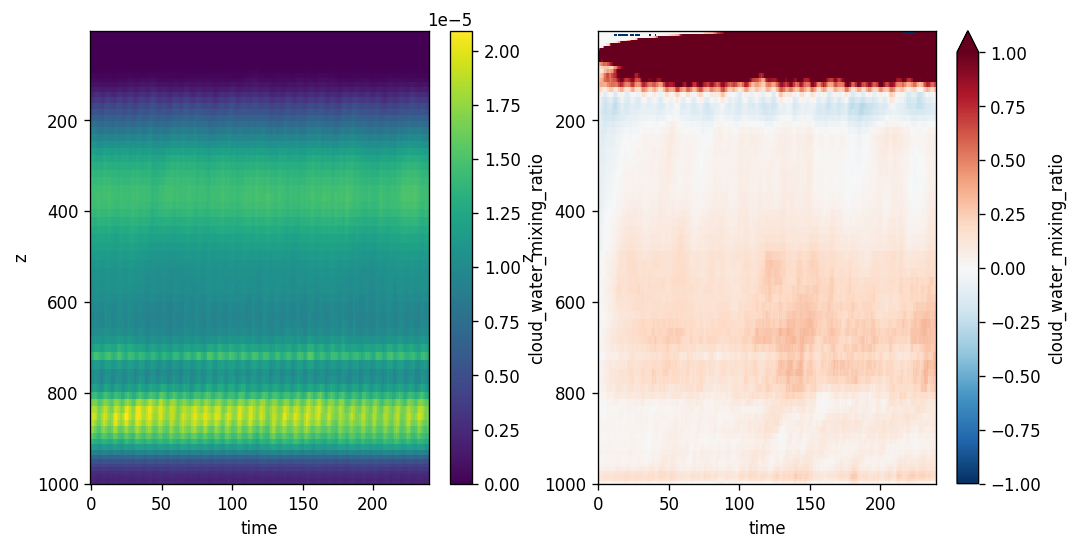

In [15]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=True)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cloud_water.plot(y="z", yincrease=False, ax=ax[0])
cloud_water_bias.plot(y="z", yincrease=False, ax=ax[1], vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

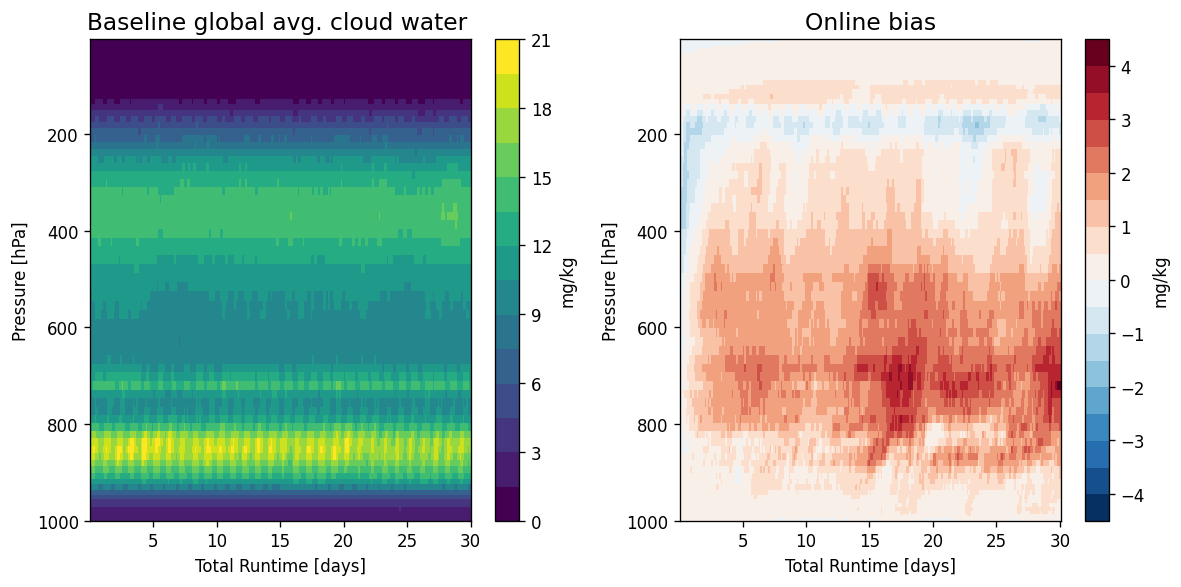

In [32]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
(cloud_water * 1e6).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label="mg/kg"))
(cloud_water_bias * 1e6).plot(y="z", yincrease=False, ax=ax[1], cmap="RdBu_r", levels=20, cbar_kwargs=dict(label="mg/kg"))
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("Pressure [hPa]")
ax[0].set_xlabel("Total Runtime [days]")
ax[1].set_xlabel("Total Runtime [days]")
ax[0].set_title("Baseline global avg. cloud water ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
plt.show()

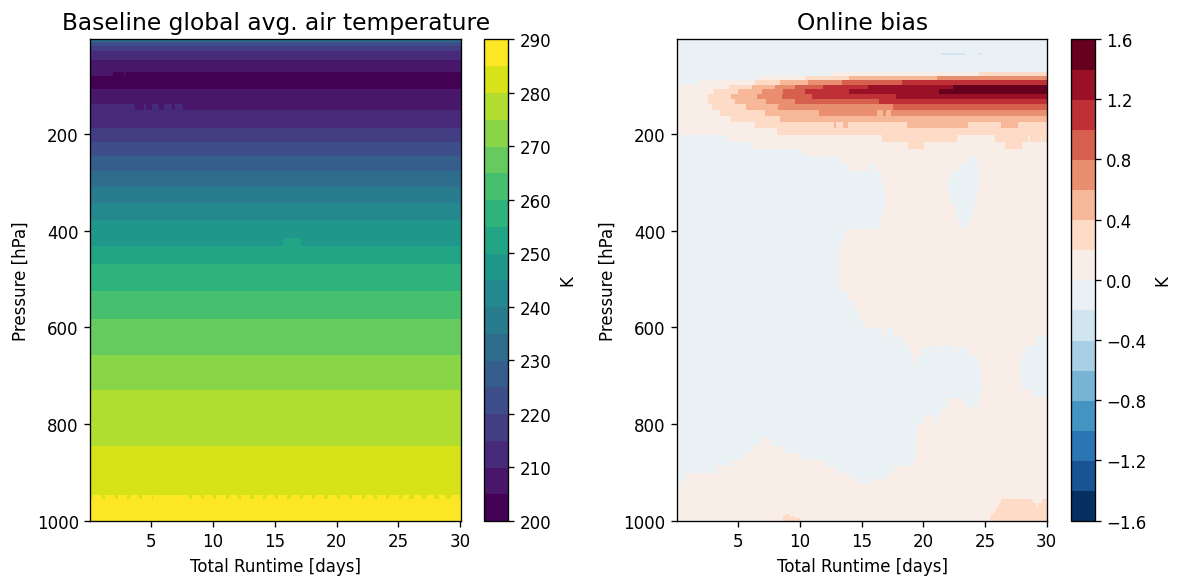

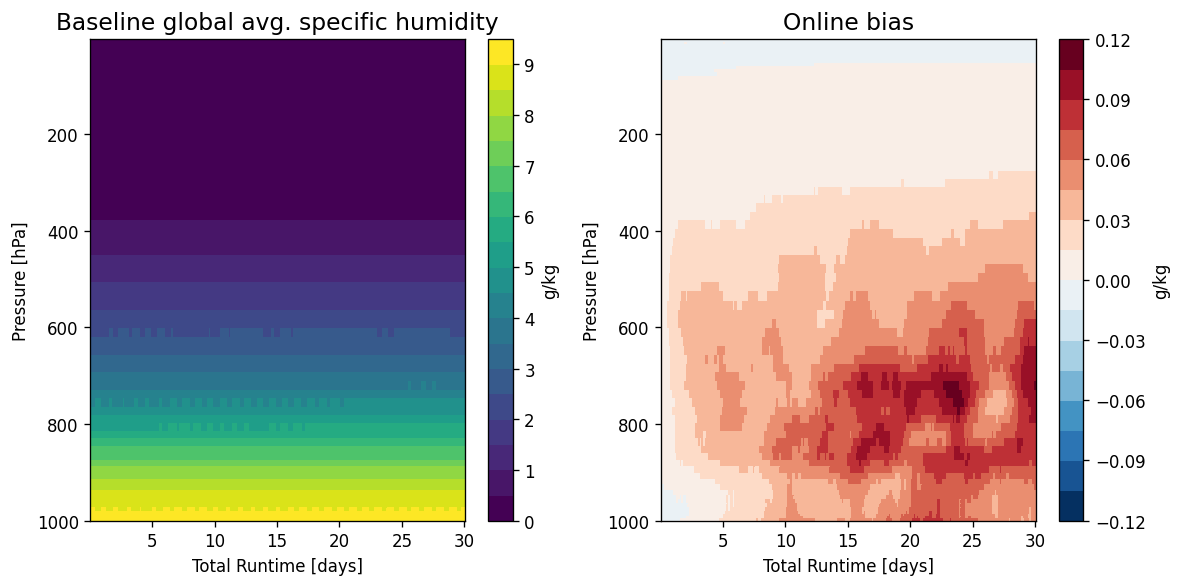

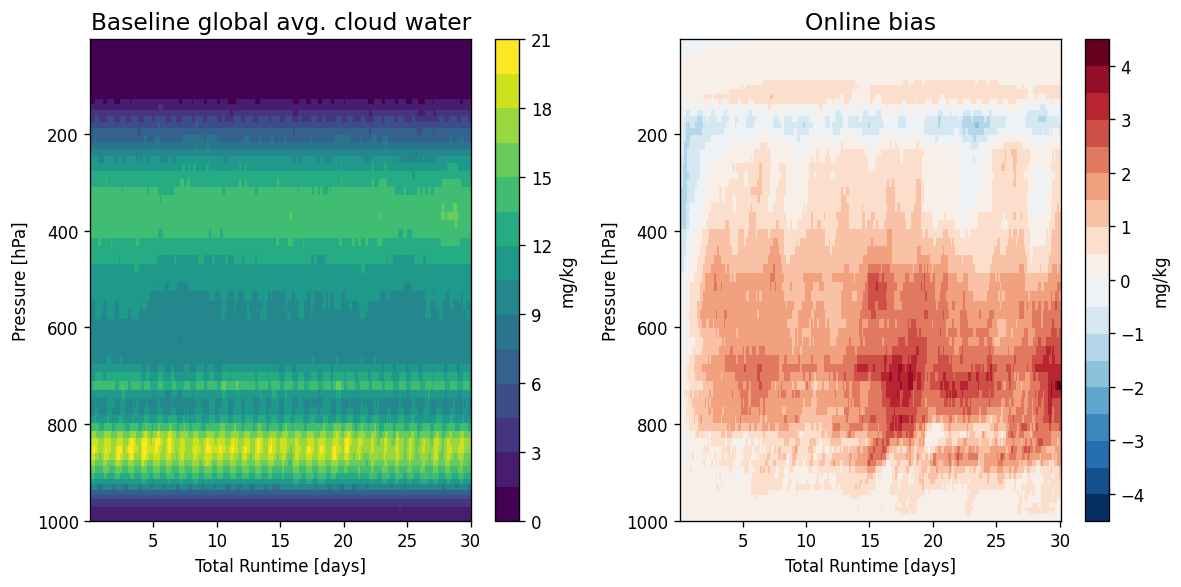

In [38]:
units = {
    "cloud_water_mixing_ratio": "mg/kg",
    "air_temperature": "K",
    "specific_humidity": "g/kg",
}

scale_factors = {
    "cloud_water_mixing_ratio": 1e6,
    "specific_humidity": 1e3,
}

simple_name = {
    "cloud_water_mixing_ratio": "cloud water",
    "air_temperature": "air temperature",
    "specific_humidity": "specific humidity",
}

for f in fields:
    baseline, bias = get_bias(f, args, results, pct=False)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * scale_factor).plot(y="z", yincrease=False, ax=ax[1], levels=20, cbar_kwargs=dict(label=unit_label))
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Pressure [hPa]")
    ax[0].set_xlabel("Total Runtime [days]")
    ax[1].set_xlabel("Total Runtime [days]")
    ax[0].set_title(f"Baseline global avg. {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()

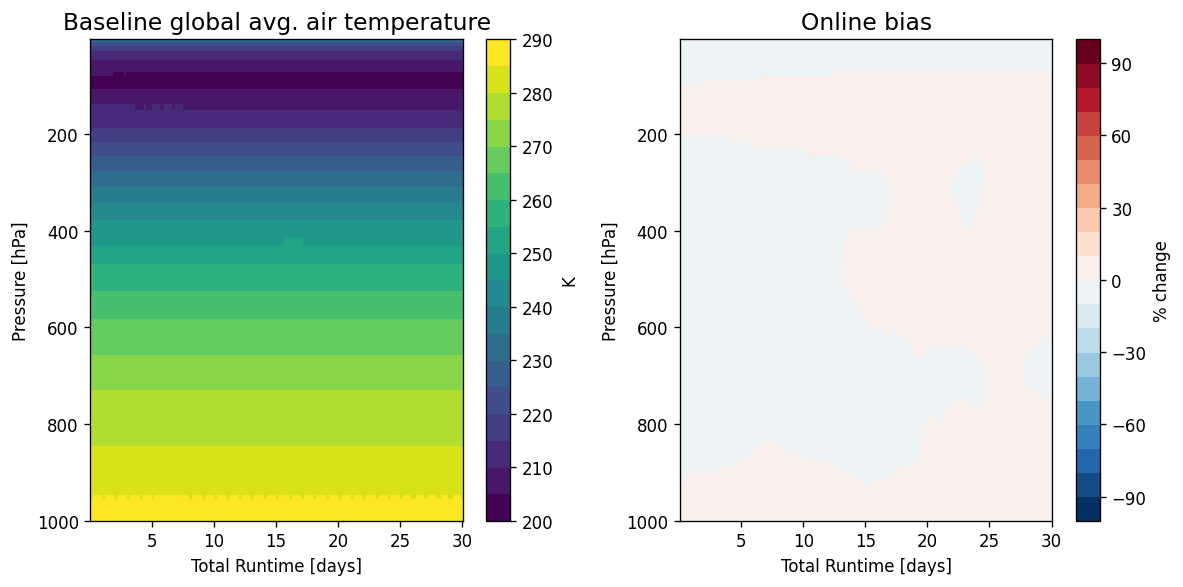

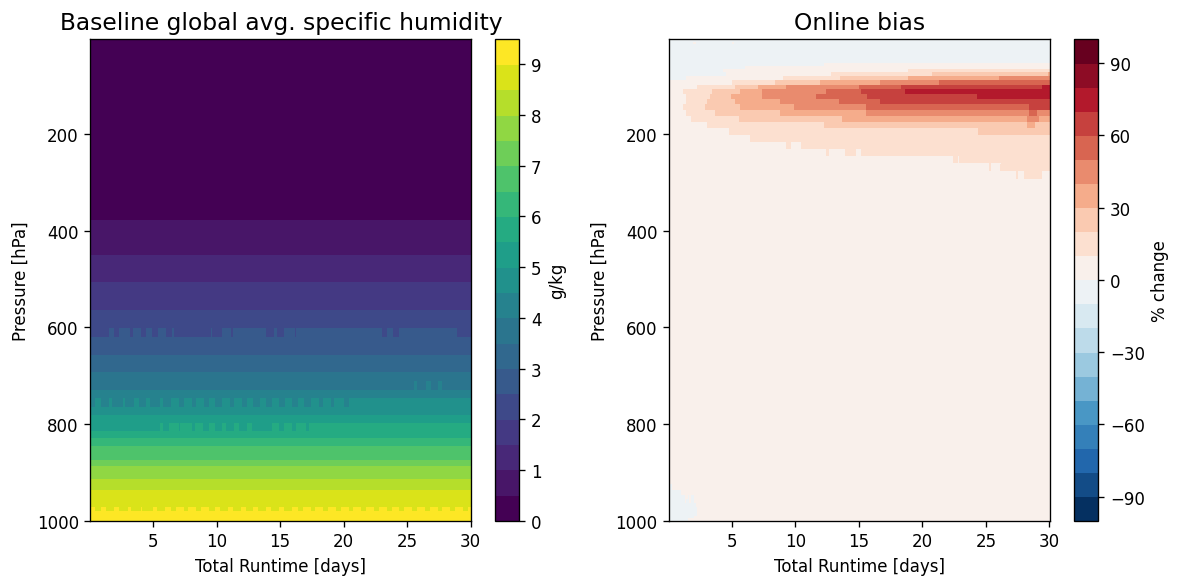

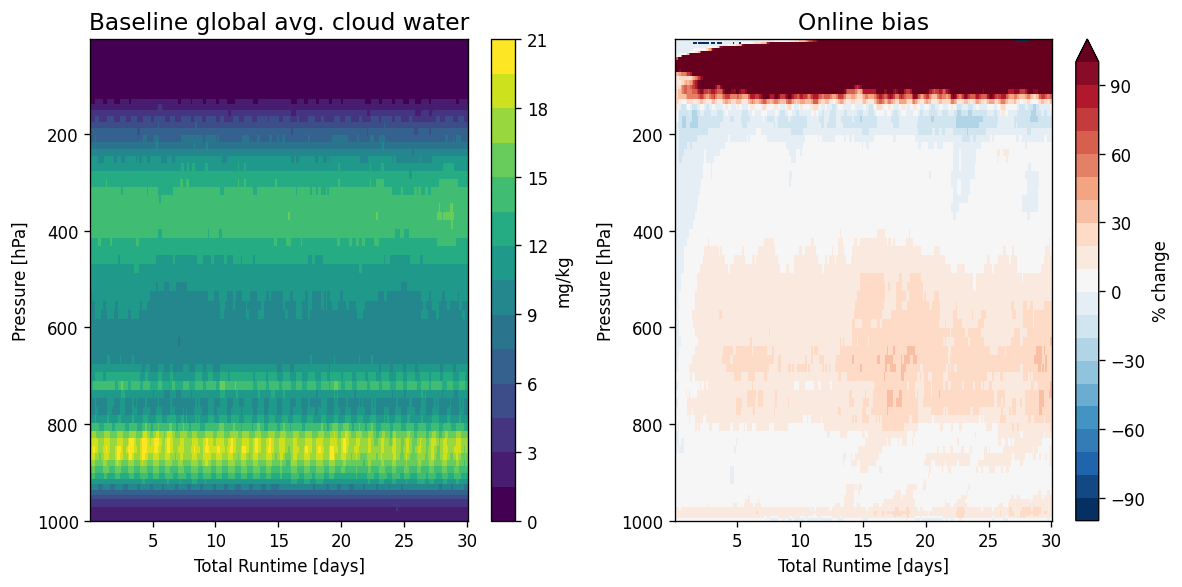

In [40]:
for f in fields:
    baseline, bias = get_bias(f, args, results, pct=True)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).plot(y="z", yincrease=False, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * 100).plot(y="z", yincrease=False, ax=ax[1], levels=21, vmin=-100, vmax=100, cmap="RdBu_r", cbar_kwargs=dict(label="% change"))
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Pressure [hPa]")
    ax[0].set_xlabel("Total Runtime [days]")
    ax[1].set_xlabel("Total Runtime [days]")
    ax[0].set_title(f"Baseline global avg. {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()